In [7]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from Dataset import Dataset
from torch.utils.data import DataLoader
torch.set_default_dtype(torch.float64)

In [8]:
x_data = np.float64(np.linspace(-15, 15, 600))
y_data = np.float64(np.sin(x_data) / x_data)

In [9]:
dataset = Dataset(x_data, y_data)
trainset, testset = torch.utils.data.random_split(dataset, [0.9, 0.1], generator=torch.Generator().manual_seed(42))

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)

activation = nn.Sigmoid()

In [10]:
class ELM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = activation(x)
        x = self.fc2(x)
        return x

# model = ELM(1, 30, 1)

In [11]:
# for i, (x, y) in enumerate(trainloader):
#     V = activation(model.fc1.bias.data.reshape(-1, 1) + model.fc1.weight.data @ x.reshape(1, -1))
#     H = torch.concatenate([torch.ones(1, len(x)), V], dim=0).T
#     T = y.reshape(1, -1).T
#     if i == 0:
#         W2 = torch.linalg.pinv(H) @ T.reshape(1, -1, 1)
#         P = torch.linalg.inv(H.T @ H + 1e-8*torch.eye(H.shape[1]))
#         # W2 = P @ H.T @ T.reshape(1, -1, 1)
#     else:
#         P = P - P @ H.T @ torch.linalg.inv(torch.eye(H.shape[0]) + H @ P @ H.T) @ H @ P
#         W2 = W2 + P @ H.T @ (T.reshape(1, -1, 1) - H @ W2)
# model.fc2.bias.data, model.fc2.weight.data = W2[0][0], W2[0][1:].T

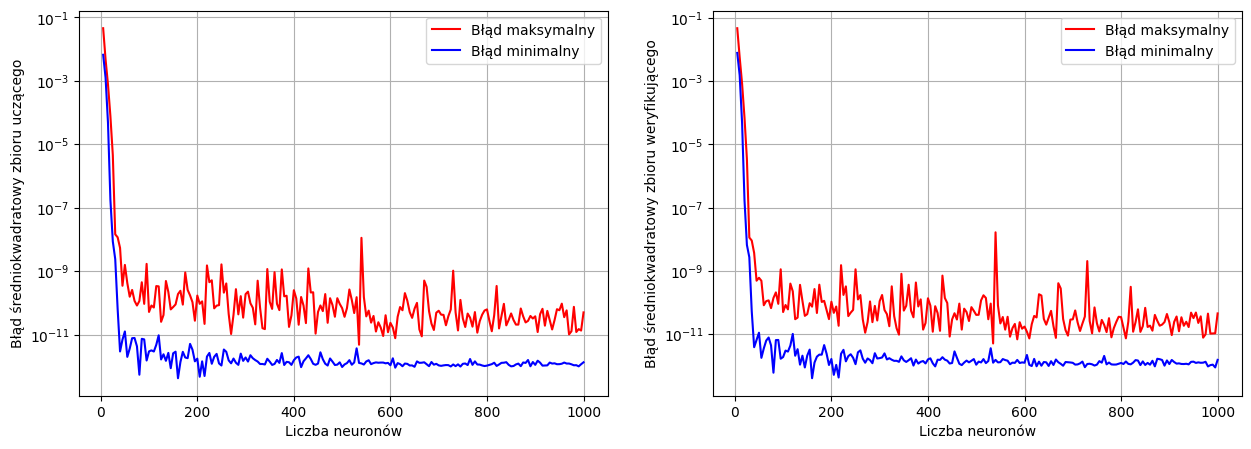

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
max_train_error = []
min_train_error = []
max_test_error = []
min_test_error = []
num_neurons = 200
for j in range(1, num_neurons+1):
    train_error = []
    test_error = []
    for i in range(10):
        model = ELM(1, 5*j, 1)
        for k, (x, y) in enumerate(trainloader):
            V = activation(model.fc1.bias.data.reshape(-1, 1) + model.fc1.weight.data @ x.reshape(1, -1))
            H = torch.concatenate([torch.ones(1, len(x)), V], dim=0).T
            T = y.reshape(1, -1).T
            if k == 0:
                W2 = torch.linalg.pinv(H) @ T.reshape(1, -1, 1) # bez regularyzacji
                P = torch.linalg.inv(H.T @ H + 1e-8*torch.eye(H.shape[1]))
                # W2 = P @ H.T @ T.reshape(1, -1, 1)
            else:
                P = P - P @ H.T @ torch.linalg.inv(torch.eye(H.shape[0]) + H @ P @ H.T) @ H @ P
                W2 = W2 + P @ H.T @ (T.reshape(1, -1, 1) - H @ W2)
        model.fc2.bias.data, model.fc2.weight.data = W2[0][0], W2[0][1:].T
        train_error.append((model(trainset[:][0].clone().detach().reshape(-1, 1))-trainset[:][1].reshape(-1, 1)).reshape(-1).pow(2).mean())
        test_error.append((model(testset[:][0].clone().detach().reshape(-1, 1))-testset[:][1].reshape(-1, 1)).reshape(-1).pow(2).mean())
    max_train_error.append(max(train_error).item())
    min_train_error.append(min(train_error).item())
    max_test_error.append(max(test_error).item())
    min_test_error.append(min(test_error).item())
ax[0].plot([5*i+5 for i in range(num_neurons)], max_train_error, 'r', label='Błąd maksymalny')
ax[0].plot([5*i+5 for i in range(num_neurons)], min_train_error, 'b', label='Błąd minimalny')
ax[0].set_ylabel('Błąd średniokwadratowy zbioru uczącego')
ax[0].set_xlabel('Liczba neuronów')
ax[0].set_yscale('log')
ax[0].grid()
ax[0].legend(loc='upper right')
ax[1].plot([5*i+5 for i in range(num_neurons)], max_test_error, 'r', label='Błąd maksymalny')
ax[1].plot([5*i+5 for i in range(num_neurons)], min_test_error, 'b', label='Błąd minimalny')
ax[1].set_ylabel('Błąd średniokwadratowy zbioru weryfikującego')
ax[1].set_xlabel('Liczba neuronów')
ax[1].set_yscale('log')
ax[1].grid()
ax[1].legend(loc='upper right')
plt.show()

Train error: 2.3514951758143596e-12
Test error: 1.6911691949470488e-12


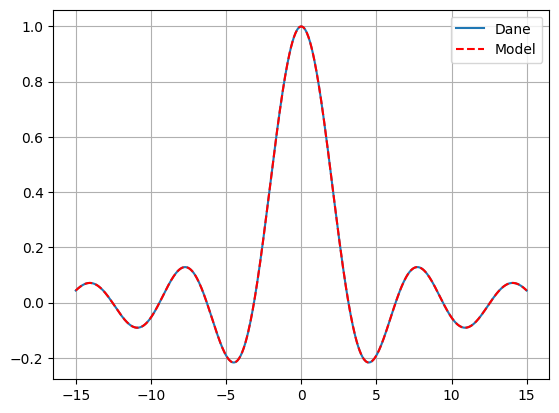

In [14]:
print(f'Train error: {(model(trainset[:][0].clone().detach().reshape(-1, 1))-trainset[:][1].reshape(-1, 1)).reshape(-1).pow(2).mean()}')
print(f'Test error: {(model(testset[:][0].clone().detach().reshape(-1, 1))-testset[:][1].reshape(-1, 1)).reshape(-1).pow(2).mean()}')
plt.plot(x_data, y_data)
plt.plot(x_data, model(torch.tensor(x_data).reshape(-1, 1)).detach().numpy(), 'r--')
plt.legend(['Dane', 'Model'], loc='upper right')
plt.grid()
plt.show()